In [4]:
import utils
import config
import os
import numpy as np

In [5]:
if __name__ == "__main__":
    df = utils.run_distance_scenario()

In [6]:
df

,distance,recording,target_bin,rr_radar,hr_radar,hr_ref,br_gt,HR_abs_err,RR_abs_err
0,40 cm,1,13,11.9,83.709677,83.733333,9.5,0.023656,2.4
1,40 cm,2,13,9.4,78.483871,81.229508,10.0,2.745637,0.6
2,40 cm,3,13,6.3,75.000000,83.300000,9.0,8.300000,2.7
3,40 cm,4,13,6.7,81.580645,82.295082,9.0,0.714437,2.3
4,80 cm,1,21,7.2,77.709677,86.245902,10.0,8.536224,2.8
5,80 cm,2,22,7.3,74.806452,81.229508,9.0,6.423057,1.7
6,80 cm,3,21,9.4,71.903226,82.901639,9.0,10.998414,0.4
7,80 cm,4,21,6.7,75.580645,81.650000,9.0,6.069355,2.3
8,120 cm,1,30,10.4,87.483871,85.262295,9.0,2.221576,1.4
9,120 cm,2,30,7.3,79.064516,83.918033,9.0,4.853517,1.7


## Wyjaśnienie zmiennych
* rr_radar: odległość radaru od badanej osoby 
* recording: numer badania
* target_bin: bin odległości wybrany jako klatka piersiowa
* rr_radar: częstość oddechu wykryta przez radar 
* hr_radar: częstość akcji serca wykryta przez radar
* hr_ref: referencyjna częstość serca (ground truth)
* br_ref: referencyjna częstość oddechu (ground truth)
* HR_abs_err: bezwzględny błąd estymacji HR
* RR_abs_err: bezwzględny błąd estymacji RR

## Wykresy pomocnicze wizualizacji sygnału 

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import config
from utils import (
    open_memmap,
    pick_target_bin_motion,
    extract_displacement,
    bandpass
)

def plot_rr_hr_signals(dist="40 cm", rec="1"):
    radar_path = os.path.join(config.BASE_RADAR, dist, rec, "data_Raw_0.bin")
    mem = open_memmap(radar_path)

    target_bin = pick_target_bin_motion(mem)
    print(f"Wybrany target_bin (klatka piersiowa): {target_bin}")
    disp_rr = extract_displacement(mem, target_bin, mode="RR")
    disp_hr = extract_displacement(mem, target_bin, mode="HR")

    t = np.arange(config.OBS_FRAMES) / config.FS

    rr_sig = bandpass(disp_rr, config.FS, *config.RR_BAND)
    hr_sig = bandpass(disp_hr, config.FS, *config.HR_BAND)
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(t, disp_rr, color="black")
    plt.title("Pełny sygnał przemieszczenia klatki piersiowej (radar)")
    plt.ylabel("Przemieszczenie [m]")
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(t, rr_sig, color="green")
    plt.title("Składowa oddechowa (RR) wykryta przez algorytm")
    plt.ylabel("Amplituda")
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(t, hr_sig, color="red")
    plt.title("Składowa serca (HR) wykryta przez algorytm")
    plt.xlabel("Czas [s]")
    plt.ylabel("Amplituda")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

✅ Wybrany target_bin (klatka piersiowa): 13


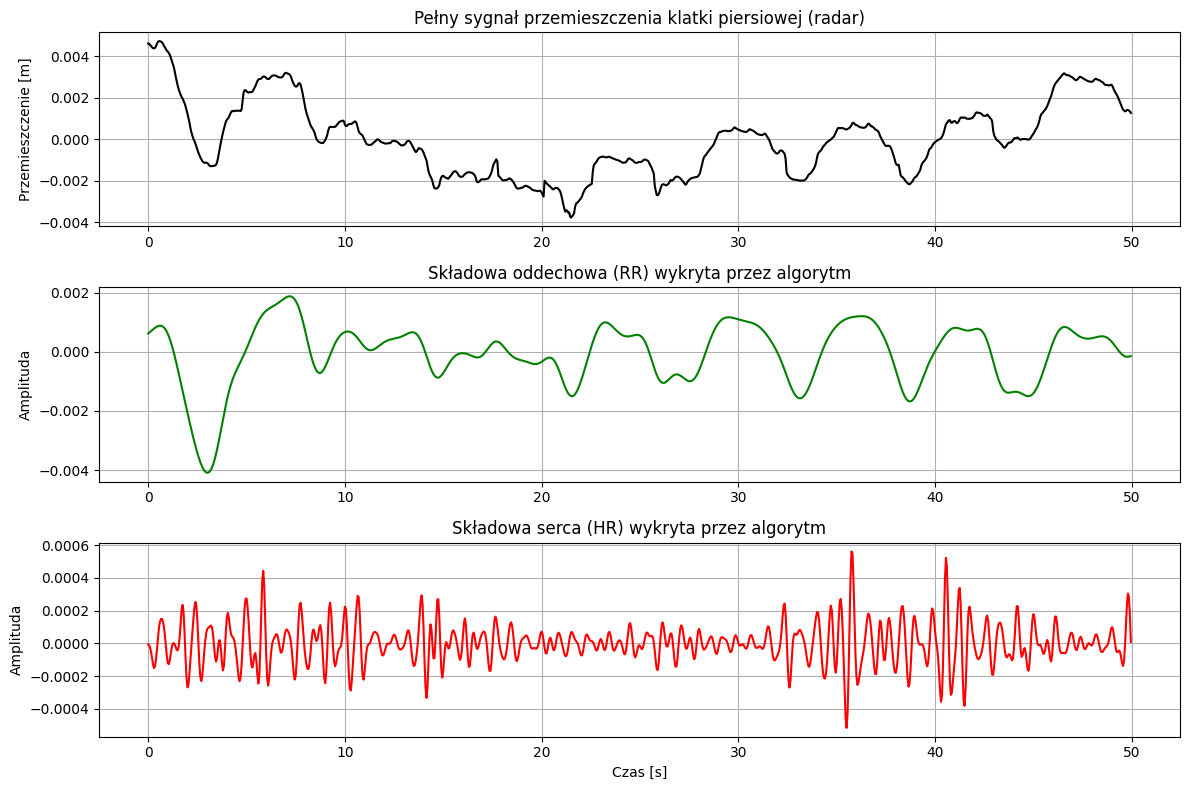

In [11]:
plot_rr_hr_signals("40 cm", "1")

## Sparwdzenie poprawności target binu

In [12]:
def visualize_target_bin_selection(dist="40 cm", rec="1"):
    radar_path = os.path.join(config.BASE_RADAR, dist, rec, "data_Raw_0.bin")
    mem = utils.open_memmap(radar_path)

    range_map = utils.build_range_map(mem)

    roi = utils.find_motion_based_roi(range_map)
    if roi is None:
        print("Nie wykryto ROI")
        return

    roi_start, roi_end = roi
    target_bin = utils.pick_target_bin_motion(mem)

    rm_dc = range_map - range_map.mean(axis=0, keepdims=True)
    motion_profile = np.var(rm_dc, axis=0)
    motion_profile /= np.max(motion_profile)

    print(f"ROI (klatka piersiowa): biny {roi_start}–{roi_end}")
    print(f"target_bin = {target_bin}")

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    im = axs[0].imshow(range_map.T, aspect="auto", origin="lower")
    axs[0].axhspan(roi_start, roi_end, color="cyan", alpha=0.3, label="ROI")
    axs[0].axhline(target_bin, color="red", linewidth=2, label="target_bin")
    axs[0].set_title("Mapa zasięgu (Range map)")
    axs[0].set_xlabel("Czas (ramki)")
    axs[0].set_ylabel("Bin odległości")
    axs[0].legend()
    plt.colorbar(im, ax=axs[0], label="Amplituda |FFT|")

    axs[1].plot(motion_profile, color="black")
    axs[1].axvspan(roi_start, roi_end, color="cyan", alpha=0.3)
    axs[1].axvline(target_bin, color="red", linestyle="--")
    axs[1].set_title("Profil ruchu (wariancja w czasie)")
    axs[1].set_xlabel("Bin odległości")
    axs[1].set_ylabel("Znormalizowana energia ruchu")
    axs[1].grid(True)

    axs[2].imshow(
        range_map[:, roi_start:roi_end].T,
        aspect="auto",
        origin="lower"
    )
    axs[2].set_title("Zoom na ROI (klatka piersiowa)")
    axs[2].set_xlabel("Czas (ramki)")
    axs[2].set_ylabel("Bin odległości")

    plt.tight_layout()
    plt.show()

ROI (klatka piersiowa): biny 9–17
target_bin = 13


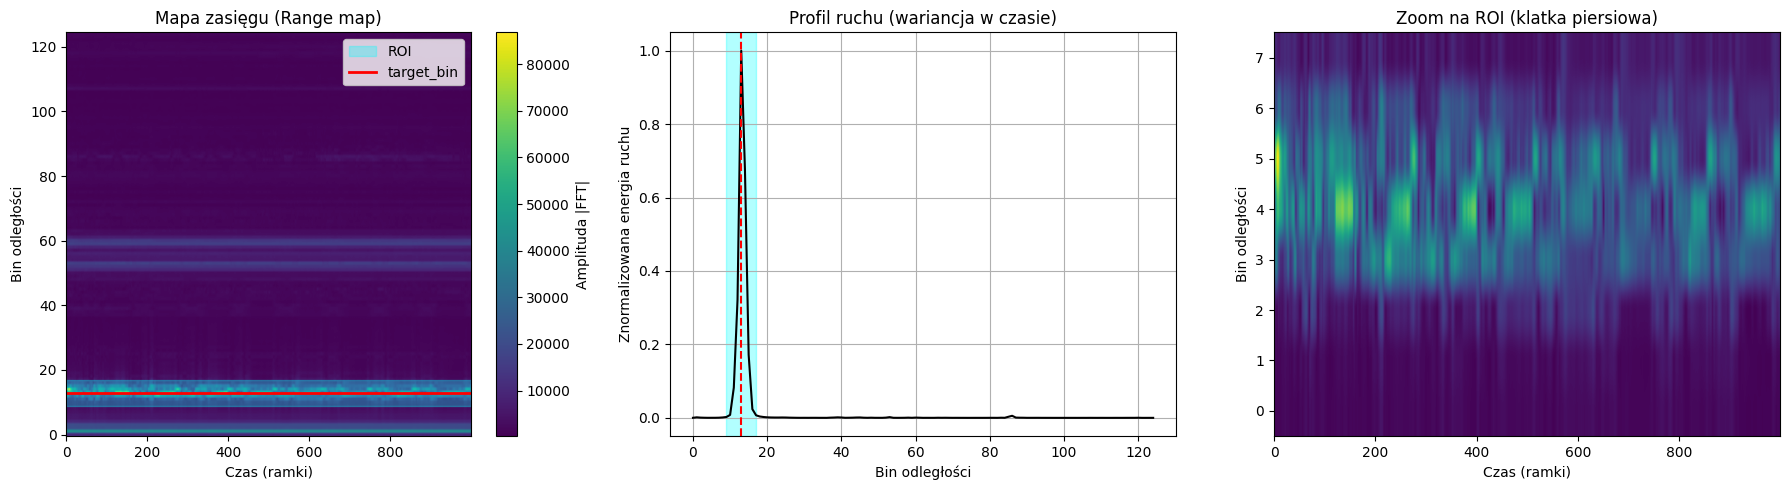

In [13]:
visualize_target_bin_selection("40 cm", "1")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import utils
import config

def visualize_detected_rr(dist="40 cm", rec="1", window_idx=0):
    """
    Wizualizacja: co algorytm uznał za RR na sygnale
    """

    radar_path = os.path.join(config.BASE_RADAR, dist, rec, "data_Raw_0.bin")
    mem = utils.open_memmap(radar_path)

    # === target bin (ten, którego używasz w pipeline) ===
    target_bin = utils.pick_target_bin_motion(mem)
    print(f"target_bin = {target_bin}")

    # === sygnał RR ===
    disp_rr = utils.extract_displacement(mem, target_bin, mode="RR")
    rr_sig = utils.bandpass(disp_rr, config.FS, *config.RR_BAND)

    t = np.arange(len(rr_sig)) / config.FS

    # === okno RR ===
    start = window_idx * config.SW
    end = start + config.W_RR
    rr_win = rr_sig[start:end]
    t_win = t[start:end]

    # === FFT → RR ===
    freqs = np.fft.rfftfreq(len(rr_win), 1 / config.FS)
    spec = np.abs(np.fft.rfft(rr_win))**2

    mask = (freqs >= config.RR_BAND[0]) & (freqs <= config.RR_BAND[1])
    f_peak = freqs[mask][np.argmax(spec[mask])]
    rr_radar = 60 * f_peak

    # === referencja ===
    br_df = utils.load_br_gt(config.BR_REF_ODS)
    br_ref = br_df[
        (br_df["distance"] == dist) &
        (br_df["recording"] == int(rec))
    ]["br_gt"].values[0]

    # === rysowanie ===
    plt.figure(figsize=(12, 5))
    plt.plot(t_win, rr_win, color="black", label="Sygnał RR")

    # linie radar RR
    T_radar = 60 / rr_radar
    for k in np.arange(t_win[0], t_win[-1], T_radar):
        plt.axvline(k, color="red", linestyle="--", alpha=0.7)

    # linie referencyjne
    T_ref = 60 / br_ref
    for k in np.arange(t_win[0], t_win[-1], T_ref):
        plt.axvline(k, color="blue", linestyle=":", alpha=0.7)

    plt.title(
        f"RR radar = {rr_radar:.2f} BPM (czerwone)\n"
        f"RR ref = {br_ref:.2f} BPM (niebieskie)"
    )
    plt.xlabel("Czas [s]")
    plt.ylabel("Amplituda")
    plt.legend([
        "Sygnał RR",
        "Oddechy radar",
        "Oddechy referencyjne"
    ])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

target_bin = 13


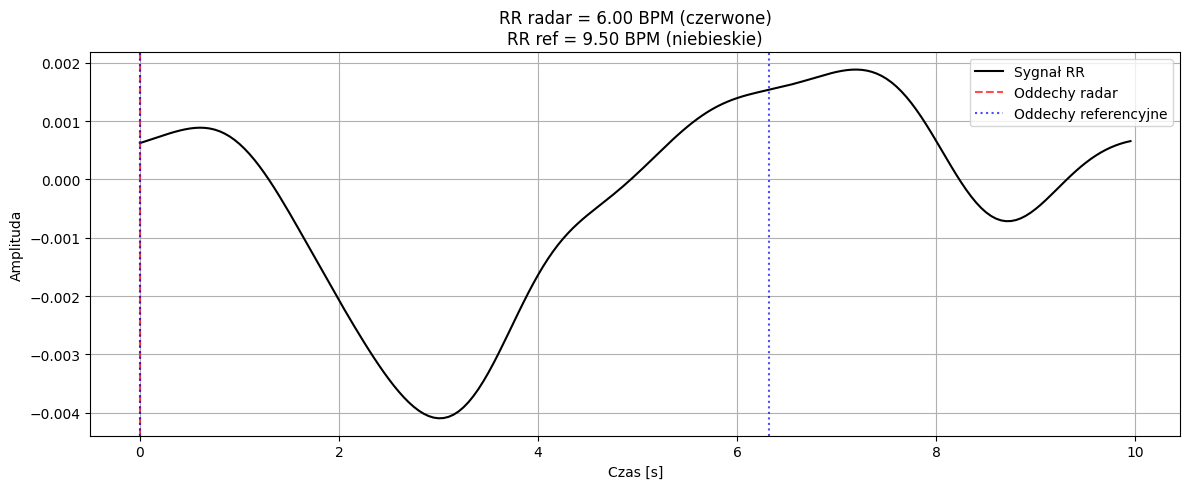

target_bin = 13


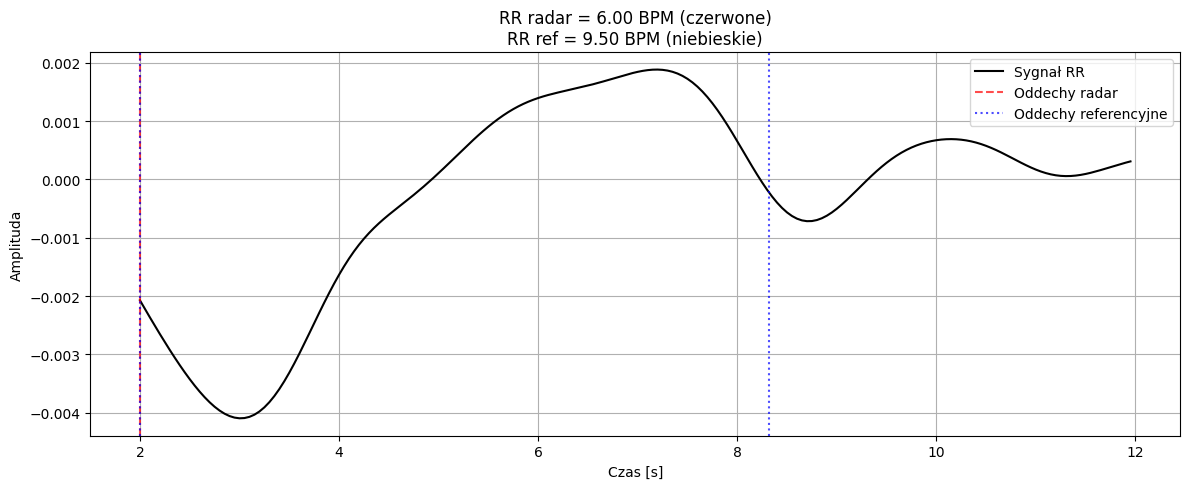

In [5]:
visualize_detected_rr("40 cm", "1", window_idx=0)
visualize_detected_rr("40 cm", "1", window_idx=2)